# movie_lens dataset preprocessing
### Import

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import json
import pandas as pd
import numpy as np
from liriscat.dataset.preprocessing_utilities import *
from liriscat.utils import utils
import torch
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.


### Load and merge dataset

In [31]:
# Specify the path to your .dat file
rating_path = '../1-raw_data/ml-1m/ratings.dat'
movie_path = '../1-raw_data/ml-1m/movies.dat'

df_movie = pd.read_csv(movie_path, delimiter='::',names=["item_id","title","dimension_id"])
df_rating = pd.read_csv(rating_path, delimiter='::', names=["user_id","item_id","correct","Timestamp"])

raw_data = pd.merge(df_movie, df_rating, on='item_id', how='inner')

raw_data.head()


/tmp/ipykernel_15552/91417673.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_movie = pd.read_csv(movie_path, delimiter='::',names=["item_id","title","dimension_id"])
/tmp/ipykernel_15552/91417673.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_rating = pd.read_csv(rating_path, delimiter='::', names=["user_id","item_id","correct","Timestamp"])


,item_id,title,dimension_id,user_id,correct,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


### Split rows with several dimensions

In [32]:
df_expanded = raw_data.assign(dimension_id=raw_data['dimension_id'].str.split('|')).explode('dimension_id').reset_index(drop=True)
df_expanded.head()

,item_id,title,dimension_id,user_id,correct,Timestamp
0,1,Toy Story (1995),Animation,1,5,978824268
1,1,Toy Story (1995),Children's,1,5,978824268
2,1,Toy Story (1995),Comedy,1,5,978824268
3,1,Toy Story (1995),Animation,6,4,978237008
4,1,Toy Story (1995),Children's,6,4,978237008


### Early stats

In [33]:
print(len(df_expanded))
all_data = df_expanded.dropna(subset=['user_id','item_id','correct','dimension_id'])
print(len(all_data))

2101815
2101815


In [34]:
stat_unique(all_data, None)
stat_unique(all_data, ['user_id', 'item_id'])
stat_unique(all_data, 'user_id')
stat_unique(all_data, 'item_id')
stat_unique(all_data, 'dimension_id')

Total length: 2101815
Number of unique [user_id,item_id]: 1000209
Number of unique user_id: 6040
Number of unique item_id: 3706
Number of unique dimension_id: 18


In [35]:
all_data.groupby("item_id")["dimension_id"].nunique().mean()

1.6708041014570967

In [36]:
genres = list(all_data['dimension_id'].unique())
genres_to_idx = {}
idx_to_genres = {}
i=0
for g in genres :
    genres_to_idx[g] =i
    idx_to_genres[i] = g
    i+=1

In [37]:
links = np.zeros((len(genres),len(genres)))
for r in all_data.groupby("item_id")["dimension_id"].unique() :
    for i,g1 in enumerate(r[:-1]) :
        for g2 in r[i+1:] :
            d = links[genres_to_idx[g1],genres_to_idx[g2]]
            links[genres_to_idx[g1],genres_to_idx[g2]] = d+1
            d = links[genres_to_idx[g2],genres_to_idx[g1]]
            links[genres_to_idx[g2],genres_to_idx[g1]] = d+1

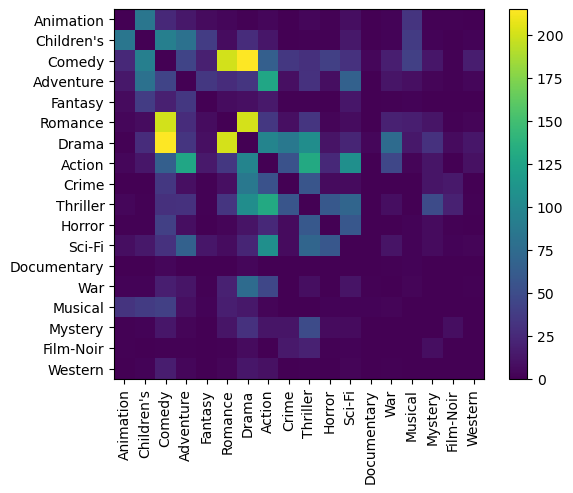

In [38]:
import matplotlib.pyplot as plt
plt.imshow(links)
plt.xticks(np.arange(len(genres)),genres, rotation=90)
plt.yticks(np.arange(len(genres)),genres)
plt.colorbar()

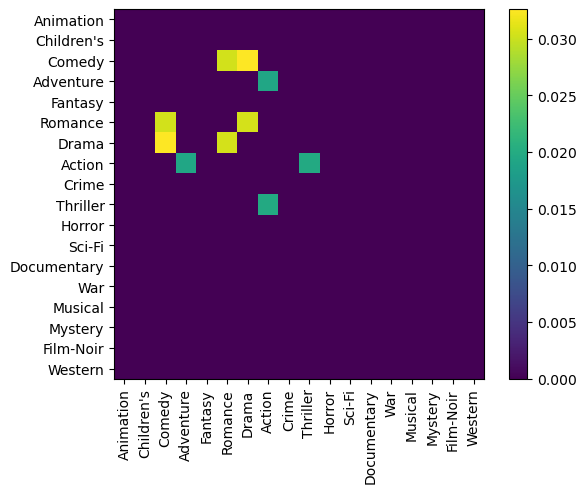

In [39]:
F = links/links.sum()
A = np.where(F>0.017,F,np.zeros_like(F))
import matplotlib.pyplot as plt
plt.imshow(A)
plt.xticks(np.arange(len(genres)),genres, rotation=90)
plt.yticks(np.arange(len(genres)),genres)
plt.colorbar()

In [40]:
sccs = tarjan_scc(np.where(A>0,1,0), idx_to_genres)
print("Strongly Connected Components:", sccs)

Strongly Connected Components: [['Animation'], ["Children's"], ['Drama', 'Romance', 'Comedy'], ['Thriller', 'Action', 'Adventure'], ['Fantasy'], ['Crime'], ['Horror'], ['Sci-Fi'], ['Documentary'], ['War'], ['Musical'], ['Mystery'], ['Film-Noir'], ['Western']]


In [41]:
dim_transform = {'Drama':'Drama_Romance_Comedy','Romance':'Drama_Romance_Comedy','Comedy':'Drama_Romance_Comedy','Thriller':'Thriller_Action_Adventure','Action':'Thriller_Action_Adventure','Adventure':'Thriller_Action_Adventure'}

In [42]:
less_connected = all_data.copy()
less_connected['dimension_id'] = less_connected['dimension_id'].apply(lambda x : dim_transform.get(x,x))
less_connected.groupby("item_id")["dimension_id"].nunique().mean()

1.4422558014031301

### Clean Nan values

In [43]:
cleaned_data = less_connected.dropna(subset=['user_id','item_id','correct','dimension_id'], axis='index')

### Remove duplicated user and id rows

In [44]:
unduplicated_data = remove_duplicates(cleaned_data,key_attrs=['user_id','item_id','dimension_id'],agg_attrs=[])

### Filter Data

In [45]:
filtered_data_0 = unduplicated_data
filtered_q_nb = 1
filtered_u_nb = 0
filtered_d_nb = 0
while filtered_q_nb!=0 or filtered_u_nb!=0 or filtered_d_nb!=0 :

    # filter items
    filtered_data_1, filtered_q_nb = densify(filtered_data_0,'item_id','user_id',50)
    # filter users
    min_nb_users_logs = 50
    filtered_data_2, filtered_u_nb = densify(filtered_data_1,'user_id','item_id',min_nb_users_logs)
    # filter knowledges
    filtered_data_3, filtered_d_nb = densify(filtered_data_2,'dimension_id','item_id',50)
    filtered_data_0 = filtered_data_3
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['user_id', 'item_id'])
stat_unique(filtered_data_0, 'user_id')
stat_unique(filtered_data_0, 'item_id')
stat_unique(filtered_data_0, 'dimension_id')

filter 1192 item_id
filter 1781 user_id
filter 2 dimension_id
filter 37 item_id
filter 19 user_id
filter 1 dimension_id
filter 0 item_id
filter 9 user_id
filter 0 dimension_id
filter 1 item_id
filter 0 user_id
filter 0 dimension_id
filter 0 item_id
filter 0 user_id
filter 0 dimension_id
Total length: 1562240
Number of unique [user_id,item_id]: 906431
Number of unique user_id: 4231
Number of unique item_id: 2421
Number of unique dimension_id: 11


### Encoding

In [46]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [47]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [48]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

### Maps creation

In [49]:
q2k, k2q = create_q2k(d_enc_data)

In [50]:
### Rescaling responses

In [51]:
d_enc_data['correct'] = d_enc_data['correct'].astype(float)

min_val = d_enc_data.groupby('item_id')['correct'].transform('min')
max_val = d_enc_data.groupby('item_id')['correct'].transform('max')

# Rescale 'correct' values per 'item_id'
d_enc_data['correct'] = (d_enc_data['correct'] - min_val) / (max_val - min_val) + 1

# Assign the rescaled data to 'rescaled_data'
resc_data = d_enc_data
print(f'min value : {resc_data.groupby("item_id")["correct"].min()}, max value : {resc_data.groupby("item_id")["correct"].max()}')

min value : item_id
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2416    1.0
2417    1.0
2418    1.0
2419    1.0
2420    1.0
Name: correct, Length: 2421, dtype: float64, max value : item_id
0       2.0
1       2.0
2       2.0
3       2.0
4       2.0
       ... 
2416    2.0
2417    2.0
2418    2.0
2419    2.0
2420    2.0
Name: correct, Length: 2421, dtype: float64


In [26]:
### Get final stats and create metadata

In [52]:
stat_unique(resc_data, None)
stat_unique(resc_data, ['user_id', 'item_id'])
stat_unique(resc_data, 'user_id')
stat_unique(resc_data, 'item_id')
stat_unique(resc_data, 'dimension_id')
stat_unique(resc_data, 'correct')

resc_data_dim_grouped_items = resc_data.groupby("dimension_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("user_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("user_id")["dimension_id"].nunique()
print('#questions/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

Total length: 1562240
Number of unique [user_id,item_id]: 906431
Number of unique user_id: 4231
Number of unique item_id: 2421
Number of unique dimension_id: 11
Number of unique correct: 7
#questions/category: 62 & 340 &  1670
#users/category: 3776 & 4043 &  4231
#categorys/question: 1 & 2 &  5
#users/question: 50 & 374 &  2731
#questions/users: 50 & 214 &  1832
#categorys/users: 5 & 11 &  11


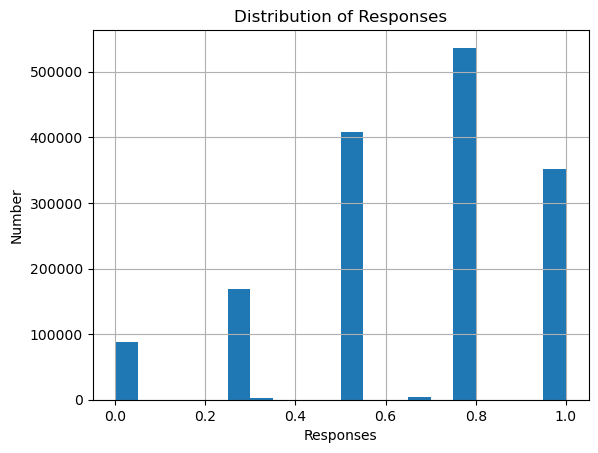

In [53]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(resc_data['correct']-1).hist(bins=20)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')
plt.savefig('../4-figs/distribution_movie_lens.png')


In [54]:
resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
metadata = get_metadata(resc_data,["user_id", "item_id", "dimension_id"])
metadata['min_nb_users_logs'] = min_nb_users_logs
metadata['max_nb_categories_per_question'] = int(np.max(resc_data_dim_grouped_items))

### Compute nb of modalities per item

In [55]:
nb_modalities = get_modalities_nb(resc_data, metadata)

### Save data, concept map, metadata and nb_modalities

In [56]:
new_order = ['user_id','item_id', 'correct', 'dimension_id']
resc_data = resc_data[new_order]

In [57]:
# save selected data
resc_data.to_csv('../1-raw_data/movie_lens_selected_data.csv', index=False)

In [58]:
# Convert int64 keys to str
q2k_str_keys = {str(key): value for key, value in q2k.items()}

# Convert sets to lists in the dictionary
q2k_json_serializable = {}
for key, value in q2k_str_keys.items():
    if isinstance(value, set):
        q2k_json_serializable[key] = list(value)
    else:
        q2k_json_serializable[key] = value

# Save concept map
with open('../2-preprocessed_data/movie_lens_concept_map.json', 'w') as f:
    json.dump(q2k_json_serializable, f)

In [59]:
# save metadata
with open('../2-preprocessed_data/movie_lens_metadata.json', 'w') as f:
    json.dump(metadata, f)

In [60]:
# save metadata
torch.save(nb_modalities,'../2-preprocessed_data/movie_lens_nb_modalities.pkl')

In [62]:
from liriscat import utils
utils.setuplogger(verbose = True,log_path = "../../logs/", log_name="liriscat", os='Windows')
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.


In [63]:
import pandas as pd
from liriscat.dataset.preprocessing_utilities import *
resc_data = pd.read_csv('../1-raw_data/movie_lens_selected_data.csv')

In [64]:
train, valid, test = split_users(resc_data, 5)

## save data

In [65]:
for i_fold, train_fold in enumerate(train):
    save_df_to_csv(train[i_fold], f'../2-preprocessed_data/movie_lens_train_{i_fold}.csv')
    save_df_to_csv(valid[i_fold], f'../2-preprocessed_data/movie_lens_valid_{i_fold}.csv')
    save_df_to_csv(test[i_fold], f'../2-preprocessed_data/movie_lens_test_{i_fold}.csv')

    train_valid_df = pd.concat([train[i_fold], valid[i_fold]])
    # Split the merged data horizontally into train and validation sets.

    quadruplet = quadruplet_format(train_valid_df)
    vertical_train, vertical_valid = split_data_vertically_unique_fold(quadruplet, valid_prop=0.1)

    save_df_to_csv(vertical_train, f'../2-preprocessed_data/movie_lens_vert_train_{i_fold}.csv')
    save_df_to_csv(vertical_valid, f'../2-preprocessed_data/movie_lens_vert_valid_{i_fold}.csv')

